# <span style='font-family: CMU Sans Serif, sans-serif;'> Addressing missing data  </span> 

This notebook looks at the amount of missing data and tries to handle it correctly. The data was sourced from Wharton Research Data Services (WRDS) and produces by the Global Factor Data (GFD) team. Below we import the necessary packages for cleaning data.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
import pandas as pd
import numpy as np
import janitor

Additionally some notebook setup is done below. Specifically we adjust the notebook width for better presentation of the data.

In [17]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)  # Use full cell width
pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks

# <span style='font-family: CMU Sans Serif, sans-serif;'> Loading data and supporting information  </span> 

Data was downloaded in `../data__collect.ipynb` and is here imported for cleaning.

In [18]:
# Define path to where the data is located
dataPath = "../data__collect/usa__gfd.parquet"

# Read data to raw data
dataRawGfdUs = pd.read_parquet(dataPath)

Besides importing data we also want information about the features provided by the GFD team. We import the label clusters and features details, which can also be used to determine basis and primary features.

In [19]:
# Raw URL to label clusters and details from GFD repo
urlLabelClustersGfd = "https://raw.githubusercontent.com/bkelly-lab/ReplicationCrisis/master/GlobalFactors/Cluster%20Labels.csv"
urlLabelDetailsGfd = "https://raw.githubusercontent.com/bkelly-lab/ReplicationCrisis/master/GlobalFactors/Factor%20Details.xlsx"

# Read dataframes
dataLabelClustersGfd = pd.read_csv(urlLabelClustersGfd)
dataLabelDetailsGfd = pd.read_excel(urlLabelDetailsGfd)

# Create list of primary characters
listPrimaryFeatures = dataLabelClustersGfd['characteristic'].tolist()

# <span style='font-family: CMU Sans Serif, sans-serif;'> Understanding data  </span>  

## <span style='font-family: CMU Sans Serif, sans-serif;'> Data documentation  </span> 

The GFD-team provides documentation for their dataset. Below are relevant notes retaining to our dataset. The Global Factor Data includes 406 characteristics and their associated factor portfolios. This is a superset of 153 factors used in this analysis. 

This section pulls out relevant information from the documentation provided by the GFD-team. Below is a table showing the most important identifiers, where sources refers to either CRSP or Compustat. Information sourced from CRPS is prefixed with `crsp_` and information sourced from Compustat is prefixed with `comp_`.

| Variable | Description                           | Example     | Note                                                  |
|----------|---------------------------------------|-------------|-------------------------------------------------------|
| `id`     | Unique security x source identifier | `100144701.0` | This should be the variable we use to identify stocks. We should make it a string. |
| `eom`    | End of month where the data is valid (information available at the end of the month)  | The `me` value for a stocks with `eom=20191231`, will be the last available market equity before or at December 31st 2019 | Should be used as time variable. |
| `excntry` | the column that identifies the country of the exchange where the security is traded | `USA` | In our case this is always `USA` |

In addition, we screened data in the SQL with the following

| Screen            | Purpose                                                    |
|-------------------|------------------------------------------------------------|
| `obs_main = 1`    | Restrict sample to one observation per security x source per month. In cases of duplicate observations this ensures that only one observation (in this case from CRSP) is collected. |
| `common = 1`      | Use only common stock.                                     |
| `exch_main = 1`   | Use only prominent exchanges                               |
| `primary_sec = 1` | Restrict sample to one primary listing each month.         |

**This means that for each `id` (identifying the stock) and `eom` identifying the end of the month were we observed the value, we have one value.** As a sanity check we make sure that there is only one date for each observation for each month (`eom`). This is done below, and it confirms that we only have one date per stock per month.

In [20]:
# Group by 'id' and 'eom' and count unique 'date'
temp = dataRawGfdUs[['id', 'eom', 'date']].groupby(['id', 'eom']).nunique().reset_index()
temp[temp['date'] != 1].empty

True

## <span style='font-family: CMU Sans Serif, sans-serif;'> Data dictionary  </span> 

Before removing/imputation, transformation, feature engineering etc. we need to understand our data; how it is structured, what each variable tells us and its type, etc. To keep track of this we create a data dictionary. We are focused on the primary features (153) which are used to describe each firm, and the basis features (39) are generally less erroneous. 

We have 153 primary features and the rest are basis features. First we confirm that we have the 153 primary features and then how many basis features we have.

In [21]:
# Create list of observed primary features and basis features
listObsPrimaryFeatures = [feature for feature in dataRawGfdUs.columns.tolist() if feature in listPrimaryFeatures]
listObsBasisFeatures = [feature for feature in dataRawGfdUs.columns.tolist() if feature not in listPrimaryFeatures]

# Count len of observed feature types
intCountBasisFeatures = len(listObsBasisFeatures)
intCountPrimaryFeatures = len(listObsPrimaryFeatures)

# Print count 
print(f"Count basis features: {intCountBasisFeatures}")
print(f"Count primary features: {intCountPrimaryFeatures}")
print(f"Count of total observed features: {dataRawGfdUs.shape[1]}")

Count basis features: 39
Count primary features: 153
Count of total observed features: 192


We have the correct amount of features for each category. The data dictionary is now created.

In [ ]:
# Initialize dictionaries
dictDataDescription = {}
dictPrimaryDataDescription = {}
dictBasisDataDescription = {}

# Iterate through primary features and collect information
for feat in listObsPrimaryFeatures:
    description = dataLabelDetailsGfd[dataLabelDetailsGfd['abr_jkp'] == feat]['name_new']
    example_value = dataRawGfdUs[feat].dropna().iloc[0] if not dataRawGfdUs[feat].dropna().empty else "N/A" 
    dictPrimaryDataDescription[feat] = {
        "Type": dataRawGfdUs[feat].dtype,
        "Description": description.values[0] if not description.empty else "N/A",
        "Range": f"[{round(dataRawGfdUs[feat].min(), 4)}, {round(dataRawGfdUs[feat].max(), 4)}]" if pd.api.types.is_numeric_dtype(dataRawGfdUs[feat].dtype) else "N/A",
        "NaNs": dataRawGfdUs[feat].isna().sum().item(),
        "Transformation": "None",
        "Outlier handled (T/F)": False,
        "Example": example_value 
    }

# Iterate through basis features
for feat in listObsBasisFeatures:
    description = dataLabelDetailsGfd[dataLabelDetailsGfd['abr_jkp'] == feat]['name_new']
    example_value = dataRawGfdUs[feat].dropna().iloc[0] if not dataRawGfdUs[feat].dropna().empty else "N/A"  # Example (non-NaN) value
    dictBasisDataDescription[feat] = {
        "Type": dataRawGfdUs[feat].dtype,
        "Description": description.values[0] if not description.empty else "N/A",
        "Range": f"[{round(dataRawGfdUs[feat].min(), 4)}, {round(dataRawGfdUs[feat].max(), 4)}]" if pd.api.types.is_numeric_dtype(dataRawGfdUs[feat].dtype) else "N/A",
        "NaNs": dataRawGfdUs[feat].isna().sum().item(),
        "Transformation": "None",
        "Outlier handled (T/F)": False,
        "Example": example_value 
    }

# Collect subdirectories
dictDataDescription = {
    "Basis": dictBasisDataDescription,
    "Primary": dictPrimaryDataDescription
}

## <span style='font-family: CMU Sans Serif, sans-serif;'> Inspecting features  </span> 

### <span style='font-family: CMU Sans Serif, sans-serif;'> Addressing redundancy  </span> 

This is primarily concerned with the basis variables that aid in stock identification. First we look at all the identifying variables. This is done below.

In [32]:
for key, val in dictDataDescription['Basis'].items():
    print(f"Key: {key.ljust(30)} dType: {str(val['Type']).ljust(30)} Example: {val['Example']}")

Key: gvkey                          dType: string                         Example: 001447
Key: iid                            dType: string                         Example: 01
Key: comp_exchg                     dType: Float64                        Example: 11.0
Key: comp_tpci                      dType: string                         Example: 0
Key: permco                         dType: Float64                        Example: 22156.0
Key: permno                         dType: Float64                        Example: 10006.0
Key: crsp_exchcd                    dType: Float64                        Example: 1.0
Key: crsp_shrcd                     dType: Float64                        Example: 10.0
Key: date                           dType: string                         Example: 1962-01-31
Key: dolvol                         dType: Float64                        Example: 3172451.5375800002
Key: eom                            dType: string                         Example: 1962-01-31
Key:


| Variable         | Description                              | Remove (Y/N) | Reason                                                 |
|------------------|------------------------------------------|--------------|--------------------------------------------------------|
| `gvkey`          | Firm identifier from Compustat           | Yes          | Do not need additional firm information from Compustat |
| `id`             | Unique security id                       | No           | Primary security identifier                            |
| `comp_exchg`     | Stock exchange code                      | Yes          | No need for exchange id in analysis                    |
| `comp_tpci`      | Issue identifier                         | Yes          | No need for issue id in analysis                       |
| `permco`         | Unique firm identifier from CRSP         | Yes          | No need for additional identifier in analysis          |
| `permno`         | Unique security identifier from CRSP     | Yes          | No need for additional identifier in analysis          |
| `crsp_exchcd`    | CRSP exchange identifier                 | Yes          | No need in analysis                                    |
| `crsp_shrcd`     | CRSP share code                          | Yes          | No need in analysis                                    |
| `date`           | Date value is observed                   | Yes          | We will use `eom` as temporal identifier               |
| `dolvol`         | Dollar volume                            | No           | Relevant information                                   |
| `eom`            | End of month                             | No           | Primary temporal variable                              |
| `ret_exc`        | Excess return current month              | No           | Information to be used                                 |
| `ret_exc_lead1m` | Excess return current next month         | No           | Primary dependent variable                             |
| `excntry`        | Exchange country                         | No           | Not directly relevant, but nice to have                |
| `fx`             | Local currency excahnge to USD           | No           | Relevant if we include multiple countries              |
| `ff49`           | Industry classifier                      | No           | Relevant information                                   |
| `gics`           | Firm GICS industry                       | No           | Relevant information                                   |
| `prc_high`       | Highest daily price                      | No           | Relevant information                                   |
| `iid`            | Two digit identifier to add to `gvkey`   | Yes          | Not Relevant information                               |
| `common`         | Common stock identifier                  | Yes          | All are $1$ due to filter                              |
| `exch_main`      | Prominent exchange identifier            | Yes          | All are $1$ due to filter                              |
| `obs_main`       | Main observation identifier              | Yes          | All are $1$ due to filter                              |
| `bidask`         | Indicator for if price is bid/ask avg.   | No           | Relevant information on how proce is calculated        |
| `primary_sec`    | Primary sector identifier                | Yes          | All are $1$ due to filter                              |
| `source_crsp`    | Identifies the source of the return data | Yes          | Not relevant where data is sourced                     |
| `curcd`          | Currency                                 | Yes          | Currency is not relevant                               |
| `prc_low`        | Lowest daily price                       | No           | Relevant information                                   |
| `me`             | Market equity                            | No           | Relevant information                                   |
| `me_company`     | Company market equity                    | No           | Relevant information                                   |
| `ret_lag_dif`    | Time Since Most Recent Return            | No           | Relevant information                                   |
| `naics`          | Firm NAICS industry                      | No           | Relevant information                                   |
| `tvol`           | Trading volume                           | No           | Relevant information                                   |
| `prc_local`      | Price local                              | Yes          | Not Relevant information                               |
| `adjfct`         | Share Adjustment Factor                  | No           | Relevant information                                   |
| `shares`         | Amount of shares                         | No           | Relevant information                                   |
| `sic`            | Firm SIC industry                        | No           | Relevant information                                   |
| `size_grp`       | Category of sizes                        | No           | Relevant information                                   |
| `ret_local`      | Return local                             | No           | Relevant information                                   |
| `ret`            | Return USD                               | No           | Relevant information                                   |


These variables are removed below.

In [2]:
# All features that should be dropped
listBasisFeaturesDrop = ["gvkey", "comp_exchg", "comp_tpci", "permco", "permno", "crsp_exchcd", "crsp_shrcd", "date", "iid", "common", "exch_main", "obs_main", "primary_sec", "source_crsp", "curcd", "prc_local"]

# Drop specified columns
dataGfdUs_v1_0 = dataRawGfdUs.drop(columns = listBasisFeaturesDrop)

NameError: name 'dataRawGfdUs' is not defined

### <span style='font-family: CMU Sans Serif, sans-serif;'> Correcting data types  </span> 

Below we make sure the all variables are of the correct type. First we inspect the observed data types for each feature.

#### <span style='font-family: CMU Sans Serif, sans-serif;'> Basis variables  </span> 

In [1]:
{feat: {"Type": details["Type"], "Example": details["Example"]} for feat, details in dictDataDescription['Basis'].items()}

NameError: name 'dictDataDescription' is not defined

# <span style='font-family: CMU Sans Serif, sans-serif;'> EDA  </span> 

In [298]:
missing_count = dataRawGfdUs[listPrimaryFeatures].isnull().sum(axis=1)

In [1]:
dataRawGfdUs.reset_index(drop=True)

NameError: name 'dataRawGfdUs' is not defined

In [ ]:
missing_counts = missing_count.value_counts().sort_index()
missing_percentages = (missing_counts / len(dataRawGfdUs))

<>:5: DeprecationWarning: invalid escape sequence '\%'
<>:5: DeprecationWarning: invalid escape sequence '\%'
/var/folders/xx/hkq2rw3j60b15rqvybvbkgwc0000gp/T/ipykernel_92091/1190701645.py:5: DeprecationWarning: invalid escape sequence '\%'
  plt.ylabel('Percentage of Rows (\%)')


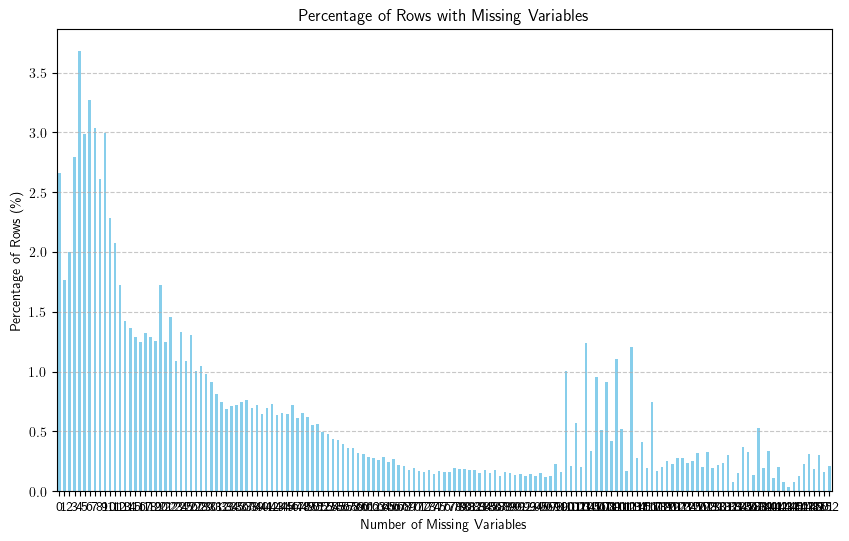

In [297]:
plt.figure(figsize=(10, 6))
missing_percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of Rows with Missing Variables')
plt.xlabel('Number of Missing Variables')
plt.ylabel('Percentage of Rows (\%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()